# Bible Text Analysis - Data Science Project

This notebook demonstrates comprehensive data science techniques applied to Biblical text analysis using various NLP frameworks and machine learning approaches.

## Project Overview
- **Objective**: Analyze Biblical text using modern NLP and data science techniques
- **Data Source**: Project Gutenberg King James Version Bible
- **Techniques**: Text preprocessing, topic modeling, sentiment analysis, word embeddings, and more

## Available Frameworks for Bible Text Analysis:
1. **NLTK** - Natural Language Toolkit for basic NLP tasks
2. **spaCy** - Industrial-strength NLP with pre-trained models
3. **Gensim** - Topic modeling and document similarity
4. **scikit-learn** - Machine learning algorithms for text
5. **TextBlob** - Simple sentiment analysis
6. **Transformers** - State-of-the-art language models (BERT, GPT)

## Data Sources for Bible Text:
1. **Project Gutenberg** - Free public domain texts (KJV)
2. **Bible API** - RESTful API with multiple translations
3. **ESV API** - English Standard Version official API
4. **YouVersion API** - Multiple translations and languages

## 1. Import Required Libraries

In [1]:
# Core Data Science Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Text Processing and NLP Libraries
import nltk
import spacy
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans

# Topic Modeling and Embeddings
import gensim
from gensim.models import Word2Vec, LdaModel
from gensim.corpora import Dictionary

# Data Acquisition
import requests
import json
import re
from urllib.request import urlopen

# Visualization
from wordcloud import WordCloud
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Set up plotting parameters
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("📊 Ready for Bible text analysis!")

✅ All libraries imported successfully!
📊 Ready for Bible text analysis!


## 2. Download and Load Bible Text Data

We'll download the King James Version Bible from Project Gutenberg, which provides free access to public domain texts.

In [2]:
# Create data directories
data_dir = Path("../data")
raw_dir = data_dir / "raw"
processed_dir = data_dir / "processed"

for directory in [data_dir, raw_dir, processed_dir]:
    directory.mkdir(exist_ok=True)

# Download Bible from Project Gutenberg
def download_bible_gutenberg():
    """Download King James Version Bible from Project Gutenberg"""
    url = "https://www.gutenberg.org/files/10/10-0.txt"
    file_path = raw_dir / "kjv_bible.txt"

    if not file_path.exists():
        print("📥 Downloading Bible from Project Gutenberg...")
        try:
            response = requests.get(url, timeout=30)
            response.raise_for_status()

            with open(file_path, 'w', encoding='utf-8') as f:
                f.write(response.text)
            print(f"✅ Bible downloaded successfully to {file_path}")
        except Exception as e:
            print(f"❌ Error downloading Bible: {e}")
            return None
    else:
        print(f"📖 Bible already exists at {file_path}")

    return file_path

# Alternative: Download from Bible API (structured data)
def download_bible_api_sample():
    """Download a sample from Bible API for structured analysis"""
    base_url = "https://bible-api.com"
    books = ["Genesis", "John", "Psalms", "Proverbs", "Matthew"]

    bible_data = []

    for book in books:
        try:
            url = f"{base_url}/{book}?translation=kjv"
            response = requests.get(url, timeout=10)

            if response.status_code == 200:
                data = response.json()
                bible_data.append(data)
                print(f"✅ Downloaded {book}")
            else:
                print(f"⚠️ Failed to download {book}: {response.status_code}")
        except Exception as e:
            print(f"❌ Error downloading {book}: {e}")

    # Save structured data
    if bible_data:
        api_file = raw_dir / "bible_api_sample.json"
        with open(api_file, 'w', encoding='utf-8') as f:
            json.dump(bible_data, f, indent=2, ensure_ascii=False)
        print(f"💾 Saved API data to {api_file}")
        return api_file

    return None

# Download the data
bible_file = download_bible_gutenberg()
api_file = download_bible_api_sample()

📖 Bible already exists at ../data/raw/kjv_bible.txt
⚠️ Failed to download Genesis: 404
⚠️ Failed to download Genesis: 404
⚠️ Failed to download John: 404
⚠️ Failed to download John: 404
⚠️ Failed to download Psalms: 404
⚠️ Failed to download Psalms: 404
⚠️ Failed to download Proverbs: 404
⚠️ Failed to download Proverbs: 404
⚠️ Failed to download Matthew: 404
⚠️ Failed to download Matthew: 404


In [3]:
# Environment Status Check
def check_environment_status():
    """Check the current environment and setup"""
    import sys
    from pathlib import Path

    print("🔍 ENVIRONMENT STATUS CHECK")
    print("=" * 40)

    # Check virtual environment
    venv_active = '.venv' in sys.executable
    print(f"Virtual Environment: {'✅ ACTIVE (.venv)' if venv_active else '❌ INACTIVE'}")

    # Check project structure
    project_dirs = ['data', 'notebooks', 'src']
    for dir_name in project_dirs:
        exists = Path(f"../{dir_name}").exists()
        print(f"Directory '{dir_name}': {'✅ EXISTS' if exists else '❌ MISSING'}")

    # Check Bible data
    bible_file = Path("../data/raw/kjv_bible.txt")
    if bible_file.exists():
        size = bible_file.stat().st_size
        print(f"Bible Data: ✅ DOWNLOADED ({size:,} bytes)")
    else:
        print("Bible Data: ❌ NOT FOUND")

    print("\n🎯 Ready for Bible Text Analysis!")

check_environment_status()

🔍 ENVIRONMENT STATUS CHECK
Virtual Environment: ✅ ACTIVE (.venv)
Directory 'data': ✅ EXISTS
Directory 'notebooks': ✅ EXISTS
Directory 'src': ✅ EXISTS
Bible Data: ✅ DOWNLOADED (4,436,268 bytes)

🎯 Ready for Bible Text Analysis!


## 3. Load and Explore the Bible Text

Let's load the downloaded Bible text and take our first look at this amazing corpus!

In [4]:
# Load the Bible text
bible_path = Path("../data/raw/kjv_bible.txt")

with open(bible_path, 'r', encoding='utf-8') as f:
    bible_text = f.read()

print("📖 BIBLE TEXT LOADED!")
print("=" * 50)
print(f"📊 Total characters: {len(bible_text):,}")
print(f"📊 Total lines: {len(bible_text.splitlines()):,}")

# Let's see the structure
lines = bible_text.splitlines()
print(f"\n🔍 First 10 lines:")
for i, line in enumerate(lines[:10]):
    if line.strip():  # Skip empty lines
        print(f"{i+1:2d}: {line[:80]}{'...' if len(line) > 80 else ''}")

print(f"\n🔍 Last 10 lines:")
for i, line in enumerate(lines[-10:], len(lines)-9):
    if line.strip():  # Skip empty lines
        print(f"{i:2d}: {line[:80]}{'...' if len(line) > 80 else ''}")

📖 BIBLE TEXT LOADED!
📊 Total characters: 4,332,679
📊 Total lines: 99,597

🔍 First 10 lines:
 1: *** START OF THE PROJECT GUTENBERG EBOOK 10 ***
 2: The Old Testament of the King James Version of the Bible
 3: The First Book of Moses: Called Genesis
 4: The Second Book of Moses: Called Exodus
 5: The Third Book of Moses: Called Leviticus
 6: The Fourth Book of Moses: Called Numbers
 7: The Fifth Book of Moses: Called Deuteronomy
 8: The Book of Joshua
 9: The Book of Judges
10: The Book of Ruth

🔍 Last 10 lines:
99588: out of the holy city, and from the things which are written in this book.
99590: 22:20 He which testifieth these things saith, Surely I come quickly.
99591: Amen.
99593: Even so, come, Lord Jesus.
99595: 22:21 The grace of our Lord Jesus Christ be with you all. Amen.
99597: *** END OF THE PROJECT GUTENBERG EBOOK 10 ***


## 4. Text Preprocessing and Cleaning

Let's clean the text by removing Project Gutenberg headers/footers and extracting just the biblical content.

In [6]:
# Clean the Bible text
def clean_bible_text(text):
    """Remove Project Gutenberg headers/footers and clean the text"""
    lines = text.splitlines()

    # Find start and end markers
    start_idx = 0
    end_idx = len(lines)

    for i, line in enumerate(lines):
        if "1:1 In the beginning God created the heaven and the earth." in line:
            start_idx = i
            break

    for i, line in enumerate(lines):
        if "*** END OF THE PROJECT GUTENBERG EBOOK" in line:
            end_idx = i
            break

    # Extract clean Bible text
    clean_lines = lines[start_idx:end_idx]

    # Remove chapter/verse numbers (optional - keeps content structure)
    # This keeps the verse numbers for now to maintain biblical structure

    return '\n'.join(clean_lines)

# Clean the text
clean_bible = clean_bible_text(bible_text)

print("🧹 TEXT CLEANING COMPLETE!")
print("=" * 50)
print(f"📊 Original length: {len(bible_text):,} characters")
print(f"📊 Clean length: {len(clean_bible):,} characters")
print(f"📊 Removed: {len(bible_text) - len(clean_bible):,} characters")

# Show first few verses
print(f"\n📖 First few verses:")
first_lines = clean_bible.splitlines()[:10]
for line in first_lines:
    if line.strip():
        print(f"   {line[:100]}{'...' if len(line) > 100 else ''}")

# Basic word analysis
words = clean_bible.split()
print(f"\n📊 WORD STATISTICS:")
print(f"   Total words: {len(words):,}")
# Fix the string issue with punctuation
punctuation = '.,!?;:"()[]{}'
unique_words = set(word.lower().strip(punctuation) for word in words)
print(f"   Unique words: {len(unique_words):,}")
print(f"   Average word length: {sum(len(word) for word in words) / len(words):.1f} characters")

🧹 TEXT CLEANING COMPLETE!
📊 Original length: 4,332,679 characters
📊 Clean length: 4,330,435 characters
📊 Removed: 2,244 characters

📖 First few verses:
   1:1 In the beginning God created the heaven and the earth.
   1:2 And the earth was without form, and void; and darkness was upon
   the face of the deep. And the Spirit of God moved upon the face of the
   waters.
   1:3 And God said, Let there be light: and there was light.
   1:4 And God saw the light, that it was good: and God divided the light
   from the darkness.

📊 WORD STATISTICS:
   Total words: 821,112
   Unique words: 17,374
   Average word length: 4.2 characters


## 5. Word Frequency Analysis

Let's discover the most common words in the Bible and create our first visualizations!

In [7]:
# Word Frequency Analysis
from collections import Counter
import string

# Clean words (remove punctuation and convert to lowercase)
def clean_word(word):
    """Clean a word by removing punctuation and converting to lowercase"""
    return word.lower().strip(string.punctuation)

# Get word frequencies
cleaned_words = [clean_word(word) for word in words if clean_word(word)]
word_freq = Counter(cleaned_words)

print("📊 WORD FREQUENCY ANALYSIS")
print("=" * 50)

# Most common words
print("🔥 TOP 20 MOST COMMON WORDS:")
for i, (word, count) in enumerate(word_freq.most_common(20), 1):
    print(f"{i:2d}. {word:<12} - {count:>6,} times ({count/len(cleaned_words)*100:.1f}%)")

# Remove stopwords for more meaningful analysis
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

english_stopwords = set(stopwords.words('english'))
# Add biblical-specific common words that might not be meaningful
biblical_stopwords = {'unto', 'thou', 'thee', 'thy', 'ye', 'hath', 'shalt', 'said'}
all_stopwords = english_stopwords.union(biblical_stopwords)

# Filter out stopwords
meaningful_words = [word for word in cleaned_words if word not in all_stopwords and len(word) > 2]
meaningful_freq = Counter(meaningful_words)

print("\n⭐ TOP 20 MEANINGFUL WORDS (excluding common words):")
for i, (word, count) in enumerate(meaningful_freq.most_common(20), 1):
    print(f"{i:2d}. {word:<15} - {count:>5,} times")

📊 WORD FREQUENCY ANALYSIS
🔥 TOP 20 MOST COMMON WORDS:
 1. the          - 64,019 times (7.8%)
 2. and          - 51,696 times (6.3%)
 3. of           - 34,667 times (4.2%)
 4. to           - 13,580 times (1.7%)
 5. that         - 12,912 times (1.6%)
 6. in           - 12,667 times (1.5%)
 7. he           - 10,419 times (1.3%)
 8. shall        -  9,838 times (1.2%)
 9. unto         -  8,997 times (1.1%)
10. for          -  8,971 times (1.1%)
11. i            -  8,854 times (1.1%)
12. his          -  8,473 times (1.0%)
13. a            -  8,177 times (1.0%)
14. lord         -  7,830 times (1.0%)
15. they         -  7,376 times (0.9%)
16. be           -  7,013 times (0.9%)
17. is           -  6,989 times (0.9%)
18. him          -  6,659 times (0.8%)
19. not          -  6,596 times (0.8%)
20. them         -  6,430 times (0.8%)

⭐ TOP 20 MEANINGFUL WORDS (excluding common words):
 1. shall           - 9,838 times
 2. lord            - 7,830 times
 3. god             - 4,443 times
 4. upon   

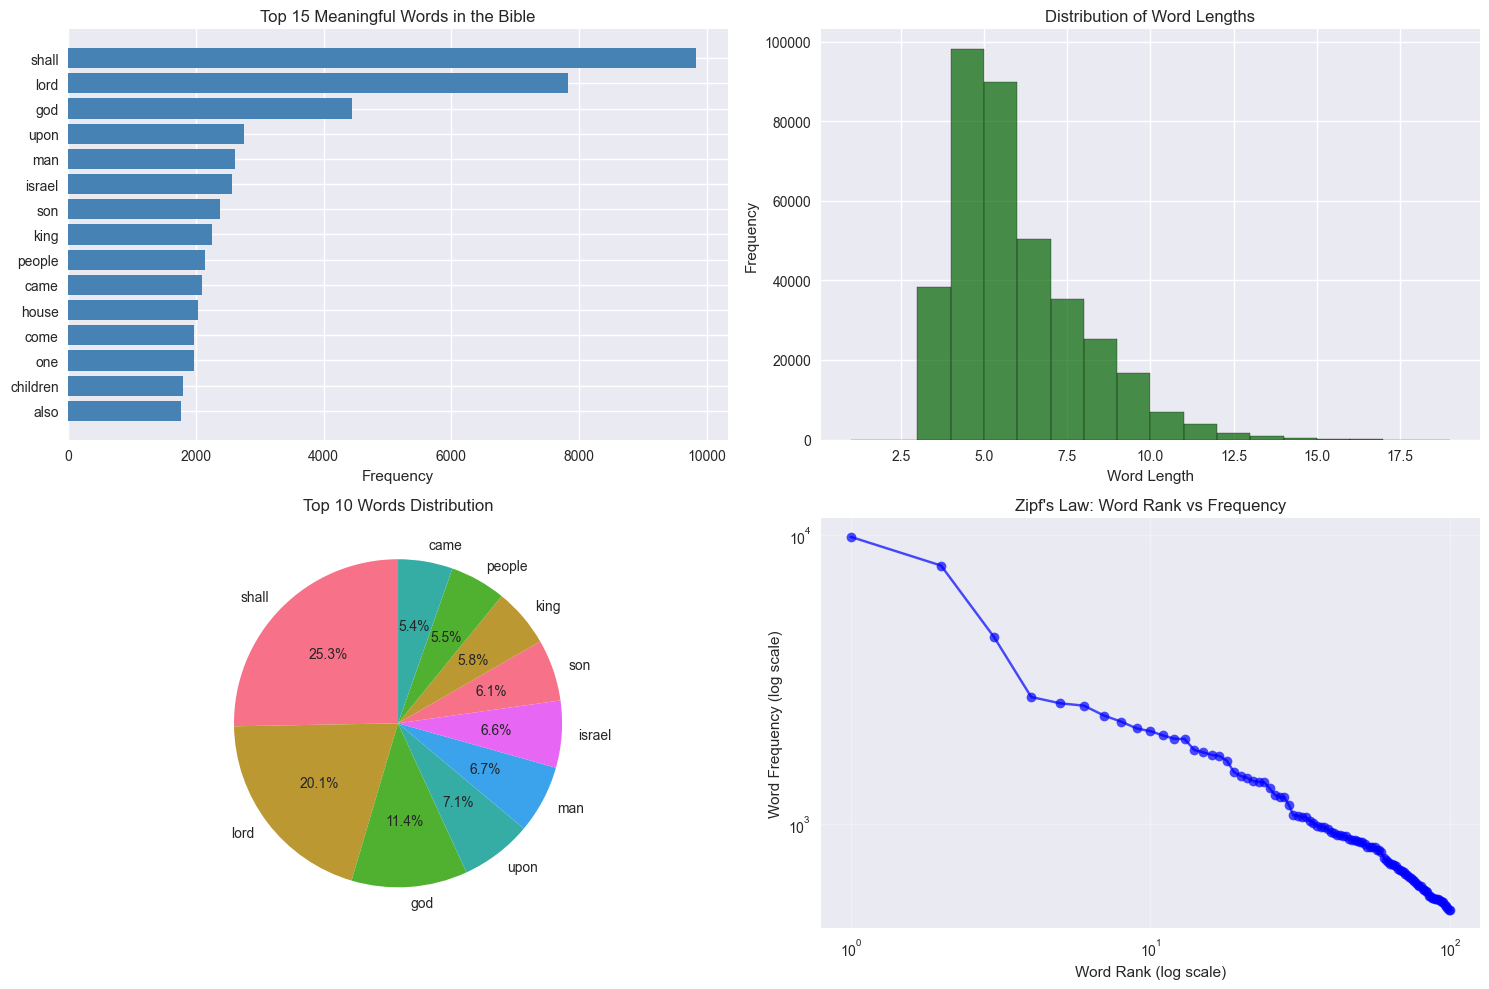


☁️ Creating Word Cloud...


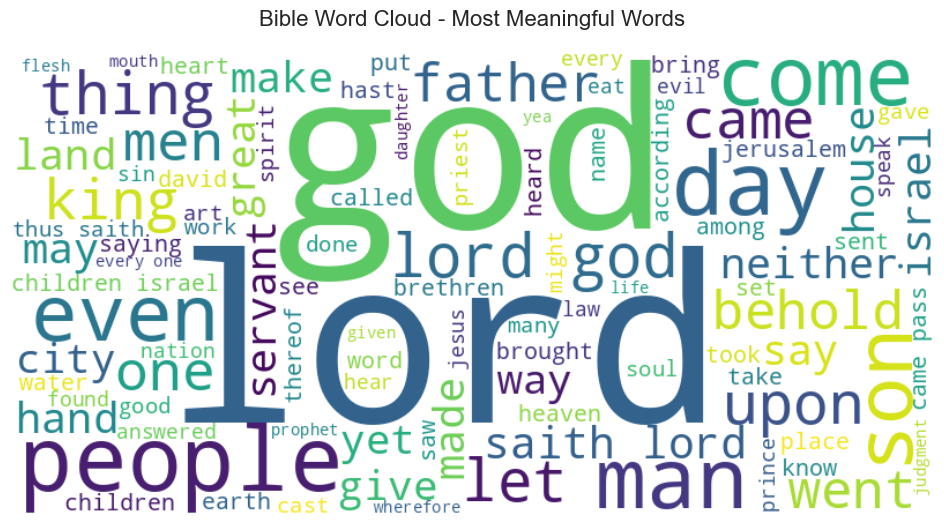


📈 SUMMARY STATISTICS:
   Most common meaningful word: 'shall' (9,838 times)
   Vocabulary richness: 0.047 (unique words / total words)
   Average meaningful word length: 5.5 characters


: 

In [ ]:
# Create visualizations
plt.figure(figsize=(15, 10))

# 1. Bar chart of top meaningful words
plt.subplot(2, 2, 1)
top_words = meaningful_freq.most_common(15)
words, counts = zip(*top_words)
plt.barh(range(len(words)), counts, color='steelblue')
plt.yticks(range(len(words)), words)
plt.xlabel('Frequency')
plt.title('Top 15 Meaningful Words in the Bible')
plt.gca().invert_yaxis()

# 2. Word length distribution
plt.subplot(2, 2, 2)
word_lengths = [len(word) for word in meaningful_words]
plt.hist(word_lengths, bins=range(1, 20), alpha=0.7, color='darkgreen', edgecolor='black')
plt.xlabel('Word Length')
plt.ylabel('Frequency')
plt.title('Distribution of Word Lengths')

# 3. Top words pie chart
plt.subplot(2, 2, 3)
top_10_words, top_10_counts = zip(*meaningful_freq.most_common(10))
plt.pie(top_10_counts, labels=top_10_words, autopct='%1.1f%%', startangle=90)
plt.title('Top 10 Words Distribution')

# 4. Zipf's Law (word rank vs frequency)
plt.subplot(2, 2, 4)
ranks = range(1, min(100, len(meaningful_freq)) + 1)
freqs = [count for word, count in meaningful_freq.most_common(100)][:len(ranks)]
plt.loglog(ranks, freqs, 'bo-', alpha=0.7)
plt.xlabel('Word Rank (log scale)')
plt.ylabel('Word Frequency (log scale)')
plt.title("Zipf's Law: Word Rank vs Frequency")
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create a simple word cloud
print("\n☁️ Creating Word Cloud...")
from wordcloud import WordCloud

# Create word cloud from meaningful words
meaningful_text = ' '.join(meaningful_words)
wordcloud = WordCloud(width=800, height=400,
                     background_color='white',
                     colormap='viridis',
                     max_words=100).generate(meaningful_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Bible Word Cloud - Most Meaningful Words', fontsize=16, pad=20)
plt.show()

# Summary statistics
print(f"\n📈 SUMMARY STATISTICS:")
print(f"   Most common meaningful word: '{meaningful_freq.most_common(1)[0][0]}' ({meaningful_freq.most_common(1)[0][1]:,} times)")
print(f"   Vocabulary richness: {len(meaningful_freq) / len(meaningful_words):.3f} (unique words / total words)")
print(f"   Average meaningful word length: {sum(len(word) for word in meaningful_words) / len(meaningful_words):.1f} characters")